# Set Up

In [1]:
# Make sure to choose py3.12 as the intepreter's kernel
import os
os.chdir("..")
from src.model.predict import *
# Recognize the current operating system
if os.name == "nt":  # Windows
    delimiter = "\\"
else:  # Unix or Linux
    delimiter = "/"

os.getcwd()

'c:\\Users\\liang.yang\\Desktop\\esmeraldas'

In [2]:
# define the global static variables for the esm features
ftp_server = "186.42.174.238"
username = "sistec"
password = "ftpst2012"

# Read the model and predict

In [3]:
from joblib import load

folder_path = "models/"
# go through all models stored in the folder_path
pkl_models = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]
# select and load the most recent trained model
most_recent_model = max(pkl_models, key=lambda x: extract_datetime_from_trained_model(x))
model = load(os.path.join(folder_path, most_recent_model))

c:\Users\liang.yang\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\liang.yang\AppData\Local\anaconda3\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import time
import pickle
import pandas as pd
from sklearn.base import BaseEstimator
from src.model.features import *
from src.model.predict import *

# Define a function to get the updated features
def get_features():
    # Your code to fetch the updated features, e.g., from a database or an API

    esm_features = get_esm_features(ftp_server, username, password)
    # esm_features done, need to finish ccs_features and wrf_features
    ccs_features = get_ccs_features(esm_shape_file, date_time)
    # Need to consider the time difference between the ccs time frame (utc+0) and the actual local time (utc+5)
    wrf_features = get_wrf_features(ftp_server, username, password)
    features = pd.merge(esm_features, ccs_features, wrf_features, on='timestamp')
    return features

# Define a function to make predictions
def make_predictions(model, features):
    if isinstance(model, BaseEstimator):
        predictions = model.predict(features)
    else:
        predictions = model(features)
    return predictions

# Run the prediction loop
while True:
    # Get the updated features
    features = get_features()

    # Make predictions
    predictions = make_predictions(model, features)

    # Output the predictions
    print(predictions)

    # Wait for 3 hours
    time.sleep(3 * 60 * 60)

# Tag different pixels with different levels

### Create a matrix with all distinct values

In [1]:
# Make sure to choose py3.12 as the intepreter's kernel
import os
os.chdir("..")
from src.model.predict import *
# Recognize the current operating system
if os.name == "nt":  # Windows
    delimiter = "\\"
else:  # Unix or Linux
    delimiter = "/"

os.getcwd()

'c:\\Users\\liang.yang\\Desktop\\esmeraldas'

In [2]:
from src.model.features import *
from src.model.predict import *

# get the size of the esmeraldas raster
# to do so, download a .tif file from the chrs data portal and then clip it

# baseline datetime is 06:00 of Feb. 20, 2024
url = 'https://persiann.eng.uci.edu/CHRSdata/PERSIANN-CCS/3hrly/rgccs3h2405106.bin.gz'

# download the .bin.gz file given the generated url
downloaded_ccs_path = download_ccs_file(url)
# set up the parameters to convert the .bin.gz file to .tif file
world_tif_filepath = 'world.tif'

# convert the downloaded ccs .bin.gz file to .tif file and correct its CRS
convert_bin_gz_to_tif(downloaded_ccs_path, world_tif_filepath)

shape_file_path = f'data{delimiter}basins{delimiter}esmeraldas.gpkg'

# clip the adjusted raster with the shapefile
clipped_tif_path = 'output_clipped.tif'
clip_raster(world_tif_filepath, shape_file_path, clipped_tif_path)

# read the clipped raster into a numpy array of features
with rasterio.open(clipped_tif_path) as src:
    clipped_array_rectangular = src.read(1)
print(f'The shape of the Esmeraldas river basin raster is {clipped_array_rectangular.shape}')

File already exists: c:\Users\liang.yang\Desktop\esmeraldas\rgccs3h2405106.bin.gz
None
The shape of the Esmeraldas river basin raster is (52, 51)


In [3]:
meta_shape = clipped_array_rectangular.shape
meta_array = create_2d_array(meta_shape)
print(f'the upper left corner of the meta array is of value {meta_array[0,0]}')
print(f'the lower right corner of the meta array is of value {meta_array[-1,-1]}')

the upper left corner of the meta array is of value 1
the lower right corner of the meta array is of value 2652


### Mask the meta rectangular array with shape files of different levels of distance
create a tif file with the secutive values ranging from 0 to its size

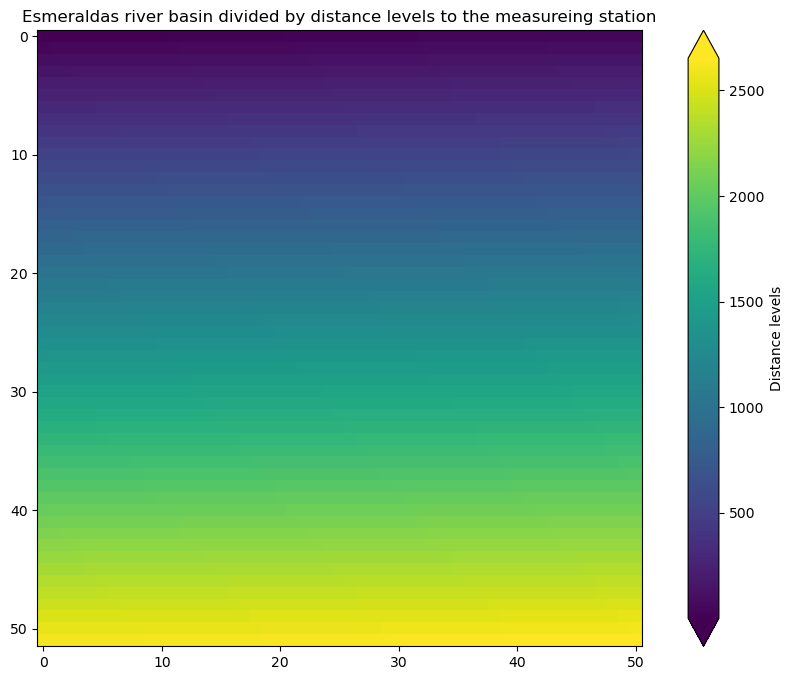

the upper left corner of the meta array is of value 1.0
the lower right corner of the meta array is of value 2652.0


In [4]:
modified_tif_path = "output_modified.tif"
modify_raster("output_clipped.tif", modified_tif_path, reassign_pixel_values)
with rasterio.open(modified_tif_path) as src:
    modified_tif_array = src.read(1)
print(f'the upper left corner of the meta array is of value {modified_tif_array[0,0]}')
print(f'the lower right corner of the meta array is of value {modified_tif_array[-1,-1]}')

Mask it with different shape files using a for loop

In [5]:
gpkg_folder = f'data{delimiter}reclass{delimiter}shape_file'
output_folder = f'data{delimiter}reclass{delimiter}cluster'

rename_gpkg_files(gpkg_folder)

# Get a list of all vector files in the mask folder
mask_files = [f for f in os.listdir(gpkg_folder) if f.endswith('.gpkg')]

arrays_dist_level = []

# Clip the raster using each vector file
for mask_file in mask_files:
    mask_path = os.path.join(gpkg_folder, mask_file)
    output_filename = os.path.splitext(mask_file)[0] + '.tif'
    output_path = os.path.join(output_folder, output_filename)

    clip_raster(modified_tif_path, mask_path, output_path)
    print(f"Clipped raster saved to {output_path}")
    with rasterio.open(output_path) as src:
        array = src.read(1)
        arrays_dist_level.append(array)
print(f"total number of distance levels: {len(arrays_dist_level)}")

# map the meta array to each of the different distance level arrays
mapping = map_values_to_array_indices(meta_array,arrays_dist_level)

Skipped 'dist_level_01.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_02.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_03.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_04.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_05.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_06.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_07.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_08.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_09.gpkg' as it doesn't match the expected pattern.
Skipped 'dist_level_10.gpkg' as it doesn't match the expected pattern.
Clipped raster saved to data\reclass\cluster\dist_level_01.tif
Clipped raster saved to data\reclass\cluster\dist_level_02.tif
Clipped raster saved to data\reclass\cluster\dist_level_03.tif
Clipped raster saved to data\reclass\cluster\dist_level_04.tif
Clipped raster saved to data\reclass\c

The mapping is only half-done, need to filter the null value in the mapping

In [6]:
# Get the boolean mask for NaN values in the array with NaN
nan_mask = np.isnan(clipped_array_rectangular)

# Create a copy of the array without NaN
modified_mapping = mapping.copy()
modified_mapping = modified_mapping.astype(float)
# Set the values in the modified array to NaN where the mask is True
modified_mapping[nan_mask] = np.nan

Convert the distance level mapping array back to .tif file but with the same crs as the esm basin

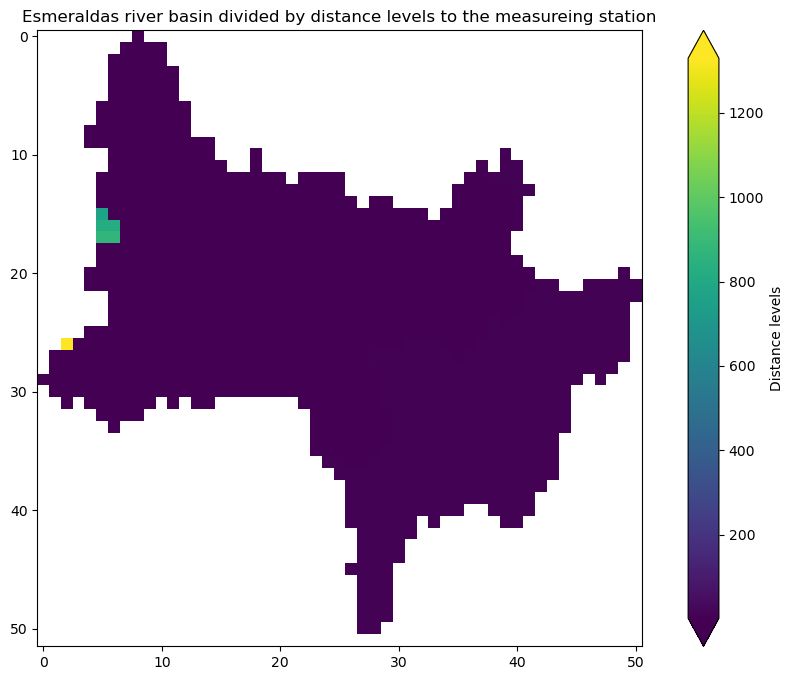

In [7]:
modify_raster(input_file= "output_modified.tif", 
              output_file= f'data{delimiter}reclass{delimiter}cluster{delimiter}dist_level_mapping.tif', 
              operation= replace_with_array, 
              new_array = modified_mapping)

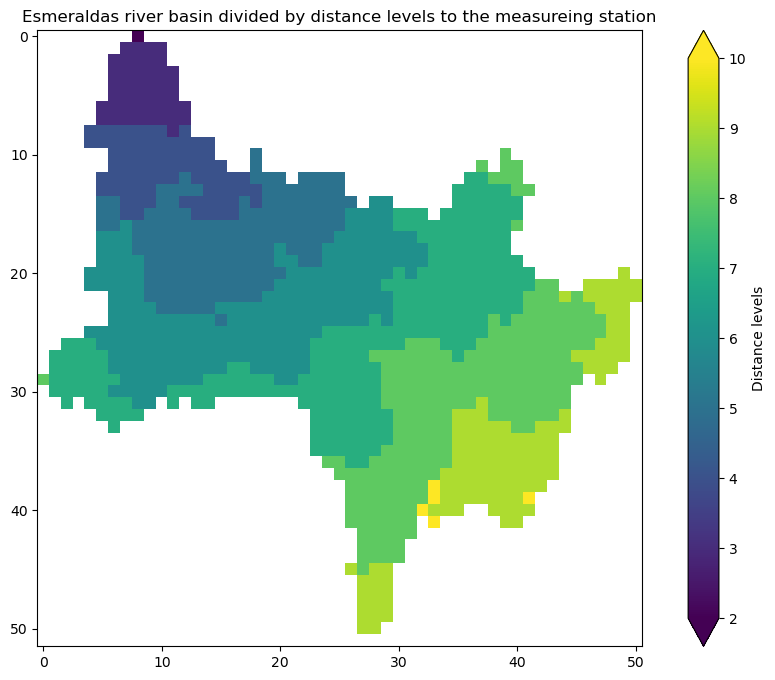

In [9]:
# replace the unchanged values of the uncovered pixels with the nearest valid value of distance levels
replaced_mapping = replace_with_nearest_valid(modified_mapping)
# modify the raster .tif file with the replace array
modify_raster(input_file= "output_modified.tif", 
              output_file= f'data{delimiter}reclass{delimiter}cluster{delimiter}dist_level_mapping.tif', 
              operation= replace_with_array, 
              new_array = replaced_mapping)

In [10]:
# check if the replaced array has the consistent number of valid pixels
stat_ana_features(replaced_mapping)

# according to the output, we can see it has 1098 valid pixels, which is consistent to the original clipped .tif file

Count (non-NaN): 1098
Sum (non-NaN): 7239.0
Mean (non-NaN): 6.592896174863388
Median (non-NaN): 7.0
Standard Deviation (non-NaN): 1.6006102519525727
Minimum (non-NaN): 2.0
Maximum (non-NaN): 10.0
Quartiles (non-NaN and non-0): [6. 7. 8.]


Now the corrected mapping information are stored both in the array `replaced_mapping`, 

and the local raster `f'data{delimiter}reclass{delimiter}cluster{delimiter}dist_level_mapping.tif'`

Now we should flatten the mapping array using the same algorithm as the with the features, and then we can tag all the features accordingly.

The flattened mapping is save at `f'data{delimiter}reclass{delimiter}features_mapping.npy'`

In [25]:
# flatten and filter the nan values of the 2d mapping to make it 1d so that in correlation with the shape of features for trainning
features_mapping_1d = flatten_and_filter_features(replaced_mapping)
print(f'The shape of the flattend mapping array is {features_mapping_1d.shape}')
features_mapping_path = f'data{delimiter}reclass{delimiter}features_mapping.npy'
np.save(features_mapping_path, features_mapping_1d)
features_mapping_saved = np.load(features_mapping_path, allow_pickle=True)

# check if the array to save and the file saved&loaded are the same
print(f'it is [{np.all(features_mapping_1d == features_mapping_saved)}] that the array to save and the file saved&loaded are the same')
print(f'it is saved at {features_mapping_path}')

The shape of the flattend mapping array is (1098,)
it is [True] that the array to save and the file saved&loaded are the same
it is saved at data\reclass\features_mapping.npy
